In [1]:
# importe l'environement
from city import City

In [2]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

import os

import stable_baselines3
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env

#### baseline

In [1]:
nb_steps = 9000

In [9]:
# aleatoire
path = './resultRandom/'
try : os.mkdir(path)
except OSError : pass
    
env = City((20, 20),path=path)
env.reset(random_start = True)

for _ in range(nb_steps):
    _, _, done, _ = env.step(env.action_space.sample())
    
    env.render("human")

    if done : env.reset()
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
# selection optimale miope
path = './BaseLineOpit/'
try : os.mkdir(path)
except OSError : pass

env = City((20, 20),path=path)
env.reset(random_start = True)

for _ in range(nb_steps):
    if (env.q__place(env.position,env.vus,0,True)>=env.q__place(env.position,env.vus,1,True)) and (env.q__place(env.position,env.vus,0,True)>=env.q__place(env.position,env.vus,2,True)) and (env.q__place(env.position,env.vus,0,True)>=env.q__place(env.position,env.vus,3,True)):
        _, _, done, _ = env.step(0)
    elif (env.q__place(env.position,env.vus,1,True)>=env.q__place(env.position,env.vus,0,True)) and (env.q__place(env.position,env.vus,1,True)>=env.q__place(env.position,env.vus,2,True)) and (env.q__place(env.position,env.vus,1,True)>=env.q__place(env.position,env.vus,3,True)):
        _, _, done, _ = env.step(1)
    elif (env.q__place(env.position,env.vus,2,True)>=env.q__place(env.position,env.vus,0,True)) and (env.q__place(env.position,env.vus,2,True)>=env.q__place(env.position,env.vus,1,True)) and (env.q__place(env.position,env.vus,2,True)>=env.q__place(env.position,env.vus,3,True)):
        _, _, done, _ = env.step(2)
    elif (env.q__place(env.position,env.vus,3,True)>=env.q__place(env.position,env.vus,0,True)) and (env.q__place(env.position,env.vus,3,True)>=env.q__place(env.position,env.vus,1,True)) and (env.q__place(env.position,env.vus,3,True)>=env.q__place(env.position,env.vus,2,True)):
        _, _, done, _ = env.step(3)
        
    env.render("human")

    if done : env.reset()
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
# bandit contextuel avec linear ucb
path = './Bandits/'
try : os.mkdir(path)
except OSError : pass

env = City((20, 20),path=path)
context = env.reset(random_start = True)

observation_shape = 1, env.observation_shape[0] * env.observation_shape[1]
arms = [{'arm_index' : i, 'alpha' : 1, 'd' : observation_shape, 'A' : np.identity(49), 'b' : np.zeros([49, 1]), 'theta' : 0} for i in range(env.action_space.n)]

for _ in range(nb_steps):
    
    #### choose arm
    highest_ucb = -1
    candidate_arms = []
    for arm_index in range(len(arms)):
        #### calculate ucb based on each arm using current covariates
        # find A inverse
        A_inv = np.linalg.inv(arms[arm_index]['A'])

        arms[arm_index]['theta'] = np.dot(A_inv, arms[arm_index]['b'])
        x = context.reshape([-1, 1])
        arm_ucb = np.dot(arms[arm_index]['theta'].T, x) +  arms[arm_index]['alpha'] * np.sqrt(np.dot(x.T, np.dot(A_inv, x)))

        if arm_ucb > highest_ucb :
            # set new max ucb
            highest_ucb = arm_ucb
            # reset candidate_arms
            candidate_arms = [arm_index]
        # if there is a tie, append to candidate_arms
        if arm_ucb == highest_ucb: candidate_arms.append(arm_index)

    # choose an arm
    arm = candidate_arms[0]
    # apply to environment
    context, reward, done, _ = env.step(arm)
    
    #### reward update
    x = context.reshape([-1,1])
    arms[arm]['A'] += np.dot(x, x.T)
    arms[arm]['b'] += reward * x 
        
    env.render("human")

    if done : env.reset()
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Algorithmes de deepRL

In [31]:
# ppo entrainement
path = './PPOstableVect/'
try : os.mkdir(path)
except OSError : pass

env = City((20, 20), start_shape = (3, 3),path=path)
env = make_vec_env(lambda: env, n_envs = 1)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=nb_steps)
model.save("PPOstableVectS")
del model 

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 313      |
|    ep_rew_mean     | 1.52e+03 |
| time/              |          |
|    fps             | 1        |
|    iterations      | 1        |
|    time_elapsed    | 1078     |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 313         |
|    ep_rew_mean          | 1.66e+03    |
| time/                   |             |
|    fps                  | 1           |
|    iterations           | 2           |
|    time_elapsed         | 2143        |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016317464 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | -0.0016     |
|    learning

In [107]:
# ppo analyse qualitative
model = PPO.load("PPOstableVectS")
env = City((20, 20))
env.reset(random_start = True)

for i in range(300):
    action, _states = model.predict(env.vus)
    obs, rewards, dones, info = env.step(action)
    env.render("human")
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#A2c

In [32]:
# A2C entrainement
path = './A2CstableVect/'
try : os.mkdir(path)
except OSError : pass

env = City((20, 20), start_shape = (3, 3),path=path)
env = make_vec_env(lambda: env, n_envs = 1)
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("A2CstableVectS")
del model 



Using cpu device
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 313       |
|    ep_rew_mean        | 1.79e+03  |
| time/                 |           |
|    fps                | 1         |
|    iterations         | 100       |
|    time_elapsed       | 260       |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.724    |
|    explained_variance | -0.000743 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 14.2      |
|    value_loss         | 308       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 313      |
|    ep_rew_mean        | 1.99e+03 |
| time/                 |          |
|    fps                | 1        |
|    iterations         | 200      |
|    time_elapsed       | 520      |
|    total_timesteps    | 1000     |
| tr

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 313       |
|    ep_rew_mean        | 1.67e+03  |
| time/                 |           |
|    fps                | 1         |
|    iterations         | 1400      |
|    time_elapsed       | 3638      |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -0.642    |
|    explained_variance | -2.38e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1399      |
|    policy_loss        | 6.08      |
|    value_loss         | 233       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 313      |
|    ep_rew_mean        | 1.66e+03 |
| time/                 |          |
|    fps                | 1        |
|    iterations         | 1500     |
|    time_elapsed       | 3899     |
|    total_timesteps    | 7500     |
| train/             

In [108]:
# A2C analyse qualitative
model = A2C.load("A2CstableVectS")
env = City((20, 20))
env.reset(random_start = True)

for i in range(300):
    action, _states = model.predict(env.vus)
    obs, rewards, dones, info = env.step(action)
    env.render("human")
cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
# DQN entrainement
path = './DQNstableVect/'
try : os.mkdir(path)
except OSError : pass

env = City((20, 20), start_shape = (3, 3),path=path)
env = make_vec_env(lambda: env, n_envs = 1)
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("DQNstableVectS")

Using cpu device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 313      |
|    ep_rew_mean      | 1.53e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 654      |
|    total_timesteps  | 1252     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 313      |
|    ep_rew_mean      | 1.5e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 1307     |
|    total_timesteps  | 2504     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 313      |
|    ep_rew_mean      | 1.5e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|  

In [110]:
#DQN analyse qualitative
model = DQN.load("DQNstableVectS")
env = City((20, 20))
env.reset(random_start = True)

for i in range(300):
    action, _states = model.predict(env.vus)
    obs, rewards, dones, info = env.step(action)
    env.render("human")
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Analyse

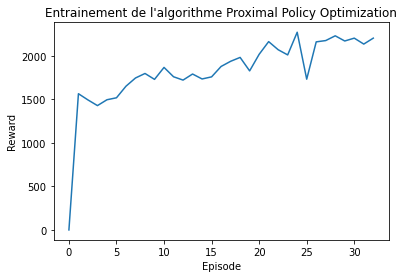

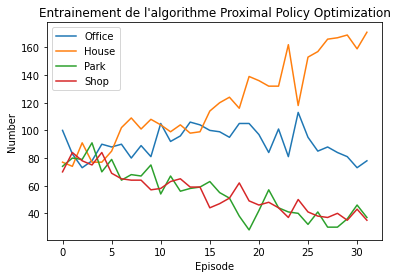

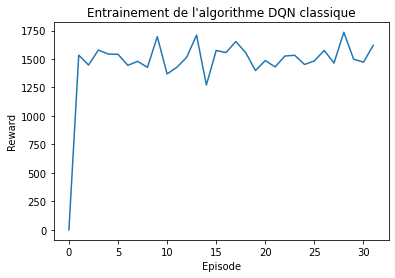

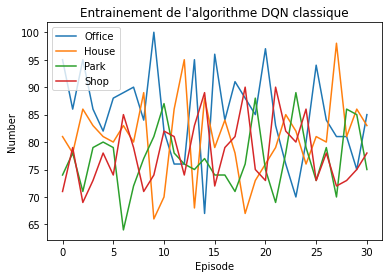

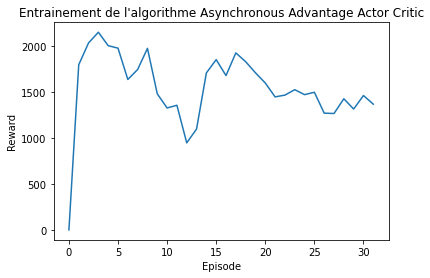

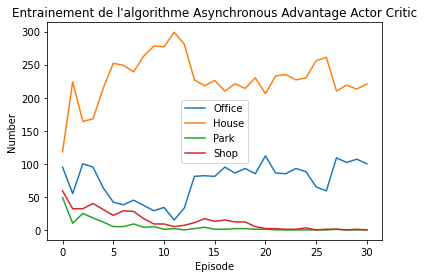

In [87]:
# RL
total=[]
noms=[]
for (Dir,nom) in zip(['PPOstableVect','DQNstableVect','A2CstableVect'],['Proximal Policy Optimization','DQN classique','Asynchronous Advantage Actor Critic']):
    with open(str(Dir)+'/rewardDQN.txt') as my_file:
        testsite_array = my_file.readlines()
    rewar=[]
    for i in testsite_array:
        nombre=i[:-1]
        rewar.append(float(nombre))    
    plt.plot(rewar)
    plt.title('Entrainement de l\'algorithme '+str(nom) )
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show() 
    total.append(rewar)
    noms.append(nom)
    with open(str(Dir)+'/DivDqn.txt') as my_file:
        testsite_array = my_file.readlines()
    rewar=[]
    for i in testsite_array:
        nombre=i[:-1]
        rewar.append(list(map(int,nombre[1:-1].split(',')) ) )
    plt.plot(rewar)
    plt.legend(['Office', 'House','Park','Shop'])
    plt.title('Entrainement de l\'algorithme ' +str(nom))
    plt.xlabel('Episode')
    plt.ylabel('Number')
    plt.show()  

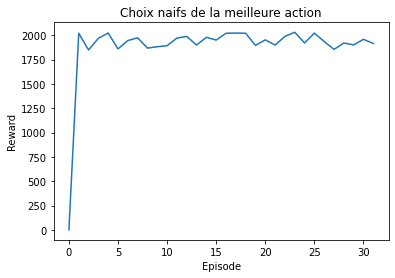

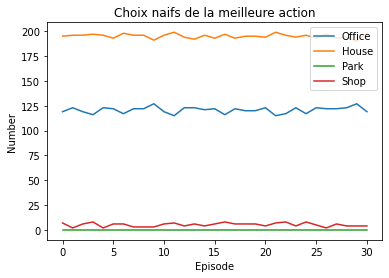

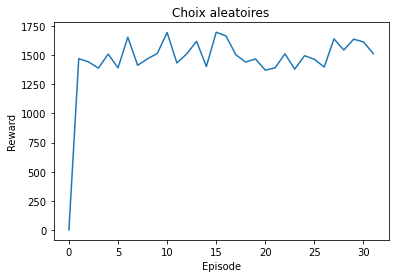

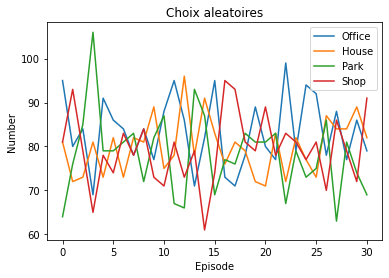

In [88]:
# Baseline
for (Dir,nom) in zip(['BaseLineOpit','resultRandom'],['Choix naifs de la meilleure action','Choix aleatoires']):
    with open(str(Dir)+'/rewardDQN.txt') as my_file:
        testsite_array = my_file.readlines()
    rewar=[]
    for i in testsite_array:
        nombre=i[:-1]
        rewar.append(float(nombre))    
    plt.plot(rewar)
    plt.title(str(nom) )
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()  
    total.append(rewar)
    noms.append(nom)
    with open(str(Dir)+'/DivDqn.txt') as my_file:
        testsite_array = my_file.readlines()
    rewar=[]
    for i in testsite_array:
        nombre=i[:-1]
        rewar.append(list(map(int,nombre[1:-1].split(',')) ) )
    plt.plot(rewar)
    plt.legend(['Office', 'House','Park','Shop'])
    plt.title(str(nom))
    plt.xlabel('Episode')
    plt.ylabel('Number')
    plt.show()  

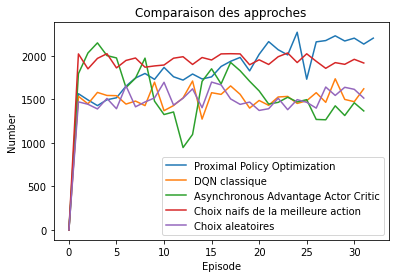

In [102]:
for i,y in zip(total,noms):
    plt.plot(i, label=y)
plt.title('Comparaison des approches')
plt.xlabel('Episode')
plt.ylabel('Number')    
plt.legend()

# Video

In [4]:
# creation des images pour la video

env = City((20, 20))
env.reset()

directory = '.\Video'
try : os.mkdir(directory)
except OSError : pass


for i in range(40):
    _, reward, done, _ = env.step(env.action_space.sample())
    image = env.render("human")
    cv2.imwrite(directory + '/' + str(i)  + ".png", image)#+ str(',') + str(y) 
    if done : env.reset()

cv2.waitKey(0)
cv2.destroyAllWindows()

[[[240 240 240]
  [240 240 240]
  [240 240 240]
  ...
  [240 240 240]
  [240 240 240]
  [240 240 240]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[240 240 240]
  [240 240 240]
  [240 240 240]
  ...
  [240 240 240]
  [240 240 240]
  [240 240 240]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ..

[[[240 240 240]
  [240 240 240]
  [240 240 240]
  ...
  [240 240 240]
  [240 240 240]
  [240 240 240]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[240 240 240]
  [240 240 240]
  [240 240 240]
  ...
  [240 240 240]
  [240 240 240]
  [240 240 240]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ..

[[[240 240 240]
  [240 240 240]
  [240 240 240]
  ...
  [240 240 240]
  [240 240 240]
  [240 240 240]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[240 240 240]
  [240 240 240]
  [240 240 240]
  ...
  [240 240 240]
  [240 240 240]
  [240 240 240]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[240 240 240]
  [255 255 255]
  [255 255 255]
  ..

In [5]:
# creation de la video a partir des images

img_array = []
# il faut mettre le chemin vers le fichier contenant toutes les images :
for filename in sorted(glob.glob(r'C:\Users\Valentin\Desktop\Video\*.png'), key=os.path.getmtime):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./Video1.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()